# Intro to the model

## Freyberg (1988) - "An Exercise in Ground-Water Model Calibration and Prediction" 


> "*The goal of parameter identification is rarely the parameter estimates. Rather, the ultimate goal is nearly always a prediction .*"
>-David Freyberg (1988)


The following series of tutorials make use of a synthetic model. This model is a variant of the model originally created by David Freyberg at Stanford University in the late 1980s. David Freyberg designed a simple model to give to a graduate class and asked them each to "calibrate" the model. Students were provided with an extensive amount of data:

1. the water level (perfectly represented) in a number of wells
2. the bedrock elevation at those same well locations
3. all the lateral aquifer geometry
4. boundary conditions including lateral flows 
5. well pumping rates 

The forecast of interest was the head if the river channel was lined (e.g. conductance reduced greatly).

There are interesting insights in the paper, but perhaps the most interesting is illustrated by the figure below: just because a model is good at fitting measurement data, does not mean it is good at making a prediction!

<img src="./intro_freyberg_model_files/cal_pred.png" style="float: center; width: 75%;  margin-bottom: 0.5em;">


You can read the original paper here:

> *Freyberg, David L. 1988. “AN EXERCISE IN GROUND-WATER MODEL CALIBRATION AND PREDICTION.” Ground Water 26 (3): 350–60. doi:10.1111/j.1745-6584.1988.tb00399.x.*

And more recently, the same exercise was revisited in a contemporary context:

> *Hunt, Randall J., Michael N. Fienen, and Jeremy T. White. 2019. “Revisiting ‘An Exercise in Groundwater Model Calibration and Prediction’ After 30 Years: Insights and New Directions.” Groundwater, July, gwat.12907. doi:10.1111/gwat.12907.* 
   

## The Modified-Freyberg Model

Using a synthetic model allows us to know the "truth". It also allows us to design it to be fast-running. Both usefull characteristics for a tutorial model. For the current set of tutorials we will be using a variant of the Freyberg model. It is also similar to the model described in the PEST++ documentation:
> White, J.T., Hunt, R.J., Fienen, M.N., and Doherty, J.E., 2020, Approaches to Highly Parameterized > Inversion: PEST++ Version 5, a Software Suite for Parameter Estimation, Uncertainty Analysis, Management > Optimization and Sensitivity Analysis: U.S. Geological Survey Techniques and Methods 7C26, 52 p., https://> doi.org/10.3133/tm7C26.

Some of the parameterisation and selected observation data are different. We also include additional particle tracking simulated using MODPATH7. 

Let's get acquainted with it.

### Admin
First some admin. You will see this in most of the tutorial notebooks. Load the dependencies and organize model folders. Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files. Simply run the next cells by pressing `shift+enter`.

In [1]:
import os
import shutil
import platform
import pandas as pd
import matplotlib.pyplot as plt
import sys
# sys.path.append(os.path.join("..", "..", "dependencies"))
import flopy
import pyemu
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

E:\Study\GMDSI_notebooks\dependencies\pyemu\pyemu\pst\pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


In [2]:
# folder containing original model files
org_ws = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')

# set a new workspace folder to avoid breaking things by mistake
sim_ws = os.path.join('freyberg_mf6')

# remove existing folder
if os.path.exists(sim_ws):
    shutil.rmtree(sim_ws)

# copy the original model folder across
shutil.copytree(org_ws, sim_ws)

# bring over the correct binaries
hbd.prep_bins(sim_ws)

Load and run the simulation. 

It should take less than a second. (If only all models were so fast!) As you can see, the model is fast and numerically stable. When undertaking highly-parameterized inversion, a model will be simulated many, many times; and run-times add up quickly! A modeller needs to take this factor into account during model design.

In [4]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws, verbosity_level=0)

# load flow model
gwf = sim.get_model()

# run the model
#sim.run_simulation()
pyemu.os_utils.run("mf6",cwd=sim_ws)

### Model Domain, BCs and Properties

The figure belows shows the model domain and boundary conditions. The model has 1 layer, 40 rows and 20 columns. Cell dimensions are 250m x 250m. There are inactive outcrop areas within the model domain (shown in black in the figure).

In [5]:
dis = gwf.dis
print(f'layers:{dis.nlay.get_data()} nrows:{dis.nrow.get_data()} columns:{dis.ncol.get_data()}')

layers:1 nrows:40 columns:20


There is a GHB along the southern boundary. All other external boundaries are no-flow. 

The surface-water system consists of a straight stream flowing north to south, which is simulated using the Streamflow Routing (SFR) package. SFR reaches raverse the model domain from row 1 to row 40 in column 16. Surface-water flow observations are monitored in reach 40 (the terminal reach). 

There are six groundwater extraction wells (red cells) and several monitoring wells (not shown). 

Water enters the model domain as recharge and stream leakage in layer 1. It leaves through groundwater discharge to the surface-water, groundwater extraction and through the downgradient GHB. 

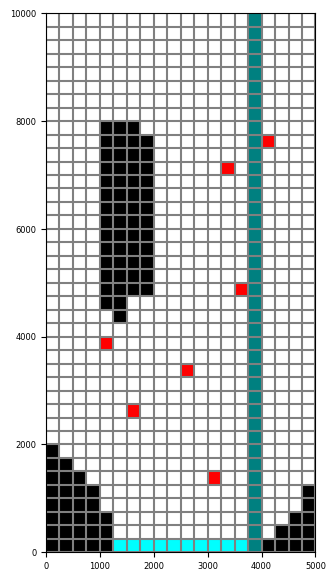

In [6]:
# plot
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)

mm.plot_grid()
mm.plot_inactive()
# Plot grid 
# you can plot BC cells using the plot_bc() 
mm.plot_bc('ghb')
mm.plot_bc('sfr')
mm.plot_bc('wel');

Take a quick look at everyone's favourite parameter, hydraulic conductivity (K):

In [7]:
for lay in range(gwf.dis.nlay.array):
    print(f'K in layer {lay+1}:', "{:10.1f}".format(gwf.npf.k.get_data(lay).mean()))

K in layer 1:       11.1


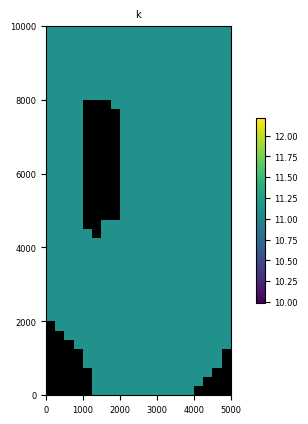

In [8]:
gwf.npf.k.plot(colorbar=True, mflay=0);

Surface topography and the bottom elevation are not uniform (see plots below), with a top and bottom elevation of 32.5m and 30m, respectively.

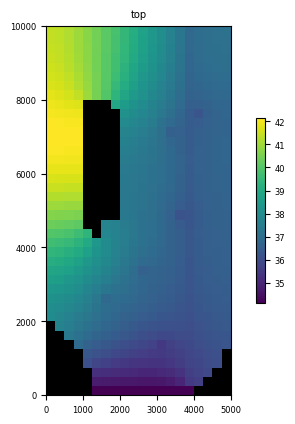

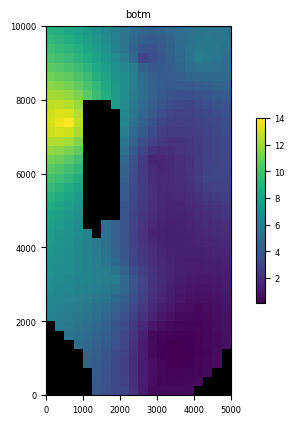

In [9]:
# plot model top
gwf.dis.top.plot(colorbar=True, masked_values=[-1049.99])

# plot bottom of bottom layer
gwf.dis.botm.plot(colorbar=True);

### Time Discretisation

The model simulates 25 stress-periods: 1 steady-state, followed by 24 transient stress periods. 

Conceptualy, the first 12 transient stress periods represent the "historical" conditions. Simulated outputs from this period (using the "true" parameter field) are used as "observations" for history matching. These represent field measurments in from our fictional site.

The last 12 transient stress periods conceptualy represent the unmeasured, future condition. The period for which predictions are required. Selected model outputs simulated during this period form a set of "forecasts" or "predicitons" of management interest. 

## Observation Data

The following field data are available as "observations" for the purposes of history matching:
 - surface-water flow at the terminal reach (stress period 2 to 13);
 - groundwater levels at two sites (stress period 2 to 13); 

"Measured" data was generated using the same model, but with higher spatial and temporal resolution (i.e. a finer grid and daily stress periods) and randomly generated parameters.

In [10]:
obs_data = pd.read_csv(os.path.join('..','..','models','daily_freyberg_mf6_truth','obs_data.csv'))
obs_data = obs_data.pivot(index='time', columns='site', values='value')
obs_data.head()

site,GAGE-1,TRGW-0-26-6,TRGW-0-3-8,TRGW-2-26-6,TRGW-2-3-8
time,,,,,
3652.5,3405.652701,37.474939,38.063501,37.265657,38.271754
3653.5,2461.823847,37.386635,38.036154,37.300383,37.918392
3654.5,3439.303917,37.512783,37.996237,37.422833,37.942242
3655.5,3197.206746,37.363104,37.995715,37.408999,38.056998
3656.5,2625.301281,37.091275,38.127423,37.436713,37.909742


Model simulated counterparts to these observations are recorded in external CSV files. Let's take a look:

In [ ]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

We can read the `sfr.csv` output file, and inspect the values:

In [ ]:
sfr_obs = pd.read_csv(os.path.join(sim_ws, 'sfr.csv'))
sfr_obs.head()

Simulated values for surface-water flow at the terminal reach are recorded in the "GAGE1" column:

In [ ]:
site = 'GAGE-1'
fig,ax=plt.subplots(1,1)
obs_data.plot(y=site, ax=ax, label='measured')
sfr_obs.plot(x='time', y=site, ax=ax, label='modelled')
ax.set_title(site);

Simulated groundwater levels are recorded in the "heads.csv" file. Several monitoring sites are simulated, however there is measured data for a only a few of these. 

The sites for which "measured data" are available are named:
 - TRGW-0-26-6
 - TRGW-0-3-8

The site naming convention is: "TRGW-layer-row-column".

In [ ]:
hds_obs = pd.read_csv(os.path.join(sim_ws, 'heads.csv'))
hds_obs.head()

Let's make a quick plot of time series of simulated groundwater levels at both measured sites:

In [ ]:
for site in ['TRGW-0-26-6','TRGW-0-3-8']:
    fig,ax=plt.subplots(1,1)
    obs_data.plot(y=site, ax=ax, label='measured')
    hds_obs.plot(x='time', y=site, ax=ax, label='modelled')
    ax.set_title(site);

Whilst we are at it, lets just make a plot of the spatial distribution of simulated heads:

In [ ]:
hdobj = gwf.output.head()
times = hdobj.get_times()
hdobj.plot(mflay=0, colorbar=True, totim=times[-1], masked_values=[1e30]);

## Forecasts

Three model simulated outputs are included as forecast "observations". These represent predictions of management interest for our imaginary case. Simulated forecasts are:
 - aggregated surface-water/grounwdater exchange for reaches 1-20 (recorded under "headwater" in the sfr.csv file) during stress period 22;
 - aggregated surface-water/grounwdater exchange for reaches 21-40 (recorded under "tailwater" in the sfr.csv file) during stress period 22;
 - groundwater level at TRGW_0_9_1 at the end of stress period 22;
 - travel time for a particle released in the north-west of the domain to exit the model domain.

These forecasts were selected to represent model outputs that are informed in varying degrees by the history matching data. Throughout the tutorials we will compare our simulated forecast and uncertainty against "true" values obtained by running the same model with which we generated "measured" observation data. 